# Exploring election tweets from Tweet the People project

I want to build a Naive Bayes classifier that predicts whether a given tweet is about a Republican or Democrat presidential candidate.

(For the purposes of this model, I'll assume that a tweet is "about a Republican" if it originally contained the words `donaldtrump`, `donald trump`, `mikepence`, or `mike pence`, and the same for the Democrat candidates. But I'll strip these actual terms out before building the model, otherwise the model wouldn't be building a prediction based on anything other than the presence of these terms.)

Before I build this model, I'd like to know:

- Is there a class imbalance that I need to take into account in my model?
- Some basic stats about the tweets:
    - Average no. words (and whether it differs by candidate)
- Bonus: Check distribution of sentiment in each ticket
- Bonus: I'll be stripping out hashtags, but I'm curious to know about the trends here.

## Step 1: reading in data, basic data cleaning

In [15]:
import re
import pandas as pd
import numpy as np
import random
from collections import Counter

import seaborn as sns

from scipy import stats

from spacy.lang.en import English
from spacy.tokenizer import Tokenizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# initialise NLP tools
SENT_ANALYSIS = SentimentIntensityAnalyzer()
nlp = English()

import warnings
warnings.filterwarnings('ignore')

In [3]:
dict_replace = {"-": " ", "\.": "", "\?": "\'", "\s+": " ", "&amp;" : "and"}

In [4]:
tweets = pd.read_csv('/Users/laraehrenhofer/Documents/Coding_Projects/git_repos/tweet-the-people-legacy/data/tweet_pg.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [225]:
# tweets = tweets[['text', 'politician', 'date', 'sentiment', 'ticket']]

Some tweets were wrongly inserted with the date as the politician -- I'm going to delete these data points from the sample. (This removes about 30 tweets.)

In [5]:
politicians = ['kamalaharris', 'donaldtrump', 'joebiden', 'mikepence']

In [6]:
def is_politician(politician):
    '''
    Returns boolean indicating whether input is a member of politicians list
    '''
    if politician in politicians:
        return politician
    else:
        return np.NaN

In [7]:
tweets['politician'] = tweets['politician'].apply(lambda x: is_politician(x))
tweets = tweets.dropna()

Next: stripping out handles, hashtags, and other undesirables.

In [8]:
def get_handles_hashtags(text):
    '''
    Returns separate lists of hashtags and user handles in the text
    '''
    handles = re.findall('\B\@\w+', text)
    hashtags = re.findall('\B\#\w+', text)
    return handles, hashtags

In [9]:
def strip_out_weird_symbols(text):
    '''
    Replaces special symbols that get messed up eg. replaces &amp; with and (as they are functionally identical)
    See dict_replace for replacements
    '''
    for key, value in dict_replace.items():
        sub = re.sub(key, value, text)
        text = sub
    text = re.sub(r'\\', '', text)
    text = re.sub('\s+', ' ', text)
    return text

In [10]:
def strip_out_handles_hashtags(text):
    '''
    Removes handles and hashtags
    '''
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    return text

In [11]:
def strip_out_links(text):
    '''
    Removes links
    '''
    text = re.sub(r'https\S+', '', text)
    return text

In [12]:
def clean_text(text):
    '''
    - Removes handles & hashtags from text
    - Handles odd symbols
    - Tokenisation
    '''
    cleaned = strip_out_links(text)
    cleaned = strip_out_weird_symbols(cleaned)
    cleaned = strip_out_handles_hashtags(cleaned)
    doc = nlp(cleaned)
    cleaned = [token.orth_.lower() for token in doc if not token.is_punct]
    cleaned = [item for item in cleaned if not re.search('\s+', item)]
    text_len = len(cleaned)
    cleaned = ' '.join(cleaned)
    return cleaned, text_len

In [19]:
# re-do sentiment analysis

def analyse_sentiment(text):
    '''
    Simple lexical approach to sentiment analysis using VADER
    Returns compound sentiment score
    '''
    sentiment = SENT_ANALYSIS.polarity_scores(text)
    return sentiment['compound']

In [13]:
tweets[['handles', 'hashtags']] = tweets.apply(lambda row: pd.Series(get_handles_hashtags(row['text'])), axis=1)

In [14]:
tweets[['clean_text', 'text_len']] = tweets.apply(lambda row: pd.Series(clean_text(row['text'])), axis=1)

In [20]:
tweets['sentiment_2'] = tweets.apply(lambda row: pd.Series(analyse_sentiment(row['clean_text'])), axis=1)

In [21]:
# save this version of tweets data for later

tweets.to_csv('./tweet_minimal_newsentiment.csv', index=False)

## Step 2: check class imbalance

Quick count of how many tweets per candidate and per ticket.

In [22]:
# count by candidate

cand = tweets.groupby(['politician']).count()
cand = cand['text']
cand

politician
donaldtrump      95423
joebiden        103594
kamalaharris     85272
mikepence        32388
Name: text, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a58631590>],
      dtype=object)

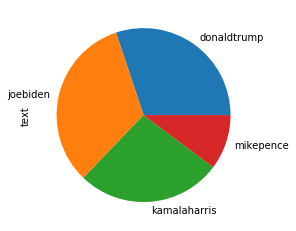

In [23]:
# comparison

cand.plot(kind='pie', subplots=True, figsize=(4, 4))

In [24]:
ticket = tweets.groupby(['ticket']).count()
ticket = ticket['text']
ticket

ticket
Democrat      188866
Republican    127811
Name: text, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x173f0bb50>],
      dtype=object)

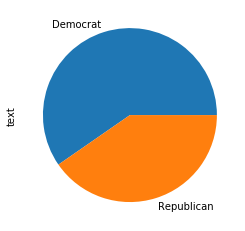

In [252]:
ticket.plot(kind='pie', subplots=True, figsize=(4, 4))

In [253]:
ticket[0]/sum(ticket)

0.5963951674529344

There's more tweets about Democrat than about Republican candidates, but that's quite probably due to the low rates of tweets about Mike Pence. Still, the discrepancy isn't monstrous (59% vs 41%), so I won't do any resampling to correct this.

## Step 3: check different distributions in word length & sentiment

In [25]:
dem = tweets[tweets['ticket']=='Democrat']
dem_len = dem['text_len']
rep = tweets[tweets['ticket']=='Republican']
rep_len = rep['text_len']

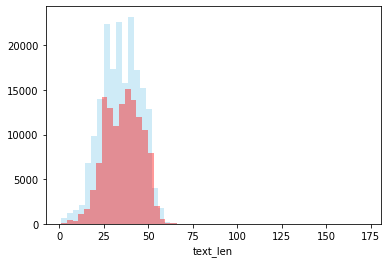

In [26]:
sns.distplot(dem_len, color='skyblue', kde=False)
sns.distplot(rep_len, color='red', kde=False)

In [284]:
# check for statistical difference in distributions

mean_dem = dem_len.mean()
mean_rep = rep_len.mean()

print(mean_dem, mean_rep)

34.63840737014878 35.94100112661952


In [287]:
stats.ttest_ind(dem_len, rep_len)

Ttest_indResult(statistic=-33.99206322086236, pvalue=8.366944077432394e-253)

I'm not sure what to make of the difference in tweet length. Bearing in mind that there are duplicates in the tweets (due to retweets) and the sheer number of Democrat-related tweets is higher, it's possible that if among the Dem sample there are some very popular and often-shared longer tweets, this would push up the mean and alter the distribution to the point of resulting in a low p-value. I'm saying this because of the 3 peaks in the Dem distribution, where it seems like three specific tweet lengths are high-frequency, suggesting many shares rather than people independently posting tweets around a certain length (where we would expect more of a normal distribution).

## Step 4: check distributions of sentiment

In [27]:
dem_sent = dem['sentiment']
rep_sent = rep['sentiment']

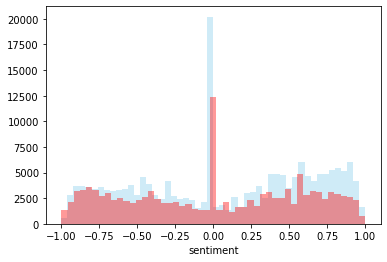

In [28]:
sns.distplot(dem_sent, color='skyblue', kde=False)
sns.distplot(rep_sent, color='red', kde=False)

In [293]:
stats.ttest_ind(dem_sent, rep_sent)

Ttest_indResult(statistic=37.99980212993464, pvalue=0.0)

No statistically significant differences between the two samples -- good news for further modelling.

In [30]:
tweets['sent_diff'] = tweets['sentiment'] - tweets['sentiment_2']

## Step 5: Checking top hashtags for each sample

In [2]:
# I'm returning to this later and just reading in the minimal tweet csv:

tweets = pd.read_csv('./tweet_minimal.csv')

In [102]:
def flatten_list(tweets, ticket):
    '''
    Flattens df containing lists of hashtags into a single list
    '''
    flat = list(tweets[tweets['ticket'] == ticket]['hashtags'].values.flatten())
    flat = [re.findall(r'#\w+', item) for item in flat if item != '[]']
    flat = [item for sublist in flat for item in sublist]
    return flat

In [103]:
rep_hashtags = flatten_list(tweets, 'Republican')
dem_hashtags = flatten_list(tweets, 'Democrat')

In [105]:
len(rep_hashtags)

57735

In [124]:
def count_hashtags(list_of_hashtags):
    '''
    turns list of hashtags into a df with sorted count of top 25 hashtags
    '''
    summary = pd.DataFrame.from_dict(Counter(list_of_hashtags), orient='index').reset_index()
    summary.columns = ['hashtag', 'count']
    summary = summary.sort_values(by='count', ascending=False).head(25)
    return summary

In [125]:
rep_sum = count_hashtags(rep_hashtags)
dem_sum = count_hashtags(dem_hashtags)

In [127]:
rep_sum

,hashtag,count
4,#DonaldTrump,1856
23,#COVID19,1446
2,#Election2020,1353
121,#BidenHarris2020,921
1,#Trump,897
7,#MAGA,794
365,#VPDebate,769
3448,#AmericaNeedsPennsylvania,727
66,#Trump2020,720
156,#MikePence,651


In [126]:
dem_sum

,hashtag,count
36,#JoeBiden,3032
10,#BidenHarris2020,2526
39,#Election2020,2416
37,#KamalaHarris,2295
826,#VPDebate,1686
60,#MAGA,1412
134,#VOTE,1263
157,#Trump2020,1221
72,#Biden,1193
132,#Trump,974
